In [1]:
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rnd
import matplotlib.pyplot as plt
from PIL import Imagea
from tqdm import tqdm
from numpy import expand_dims

import os
import requests
import zipfile
import glob


from os import listdir
from os.path import isdir, isfile, join

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder



In [2]:
def plot_augimages(paths, datagen):

  num_paths = len(paths)

  # Twórz subplot z 2x3 kafelkami
  plt.figure(figsize=(10, num_paths*2))

  for i, image_path in enumerate(paths):
      # Wczytaj oryginalny obrazek
      original_image = Image.open(image_path)
      original_image = original_image.resize((224,224))

      plt.subplot(num_paths, 5, 5 * i + 1)
      plt.imshow(original_image)
      plt.axis('off')
      plt.title(f"Oryginalny {i+1}")

      # Konwertuj oryginalny obrazek do tablicy NumPy (multi-channel 2D image)
      original_image_np = np.array(original_image)

      # Dodaj dodatkowy wymiar, jeśli obraz jest 2D (np. szarość)
      if len(original_image_np.shape) == 2:
          original_image_np = np.expand_dims(original_image_np, axis=-1)

      # Generuj i wyświetl 4 warianty obrazu
      for j in range(4):
          augmented_image = datagen.random_transform(original_image_np)
          plt.subplot(num_paths, 5, i * 5 + j + 2)
          plt.imshow(augmented_image)
          plt.axis('off')
          plt.title(f"Wariant {i+1}-{j+1}")

  plt.tight_layout()
  plt.show()

In [4]:
def plot_history(history):
    #Plot the Loss Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['loss'],'r',linewidth=3.0)
    plt.plot(history.history['val_loss'],'b',linewidth=3.0)

    plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Loss',fontsize=16)
    plt.title('Loss Curves',fontsize=16)
    plt.show()

    #Plot the Accuracy Curves
    plt.figure(figsize=[8,6])

    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b',linewidth=3.0)

    plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
    plt.xlabel('Epochs ',fontsize=16)
    plt.ylabel('Accuracy',fontsize=16)
    plt.title('Accuracy Curves',fontsize=16)
    plt.show()

# Import data

In [5]:
target_directory = 'data/'

zip_url = 'https://www.muratkoklu.com/datasets/vtdhnd10.php'

os.makedirs(target_directory, exist_ok=True)
response = requests.get(zip_url)
zip_path = os.path.join(target_directory, 'data.zip')

with open(zip_path, 'wb') as zip_file:
    zip_file.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(target_directory)

In [6]:
target_directory = 'data/'
data_dir = os.path.join(target_directory, 'Grapevine_Leaves_Image_Dataset/*')

data = []
labels = []


for class_folder in glob.glob(data_dir):
    label = os.path.basename(class_folder)

    for image_path in glob.glob(os.path.join(class_folder, '*.png')):
        labels.append(label)
        data.append(image_path)

In [7]:
print(len(data))

500


In [8]:
image = Image.open("/content/data/Grapevine_Leaves_Image_Dataset/Ak/Ak (1).png")

# Sprawdź tryb (system kolorów) obrazu
color_mode = image.mode

# Wyświetl tryb
print("System kolorów obrazu:", color_mode)

System kolorów obrazu: RGBA


# Split the data

In [9]:
df = pd.DataFrame({'path': data, 'class': labels})

In [10]:
df.head()

,path,class
0,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (57)...,Ak
1,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (88)...,Ak
2,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (91)...,Ak
3,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (49)...,Ak
4,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (14)...,Ak


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['path'], df['class'], test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.11)

In [12]:
df_train = pd.concat([X_train, y_train], axis =1)
df_val = pd.concat([X_val, y_val], axis =1)
df_test = pd.concat([X_test, y_test], axis =1)

In [13]:
df_train.head()

,path,class
316,data/Grapevine_Leaves_Image_Dataset/Ala_Idris/...,Ala_Idris
4,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (14)...,Ak
355,data/Grapevine_Leaves_Image_Dataset/Ala_Idris/...,Ala_Idris
332,data/Grapevine_Leaves_Image_Dataset/Ala_Idris/...,Ala_Idris
77,data/Grapevine_Leaves_Image_Dataset/Ak/Ak (96)...,Ak


# Generators

In [141]:
resnet50_train_datagen = ImageDataGenerator(
    rotation_range=90,
    zoom_range=0.10,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

resnet50_datagen = ImageDataGenerator(preprocessing_function = tf.image.rgb_to_grayscale)

train_generator_resnet50 = resnet50_train_datagen.flow_from_dataframe(
        df_train,
        #color_mode = 'grayscale',
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe( #flow_from_directory
        df_val,
        #color_mode = 'grayscale',
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=128,
        class_mode="categorical",
        shuffle=True,
)
test_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        df_test,
        #color_mode = 'grayscale',
        x_col='path',
        y_col='class',
        target_size=(227, 227),
        batch_size=128,
        class_mode="categorical",
        shuffle=False,
)


Found 400 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.


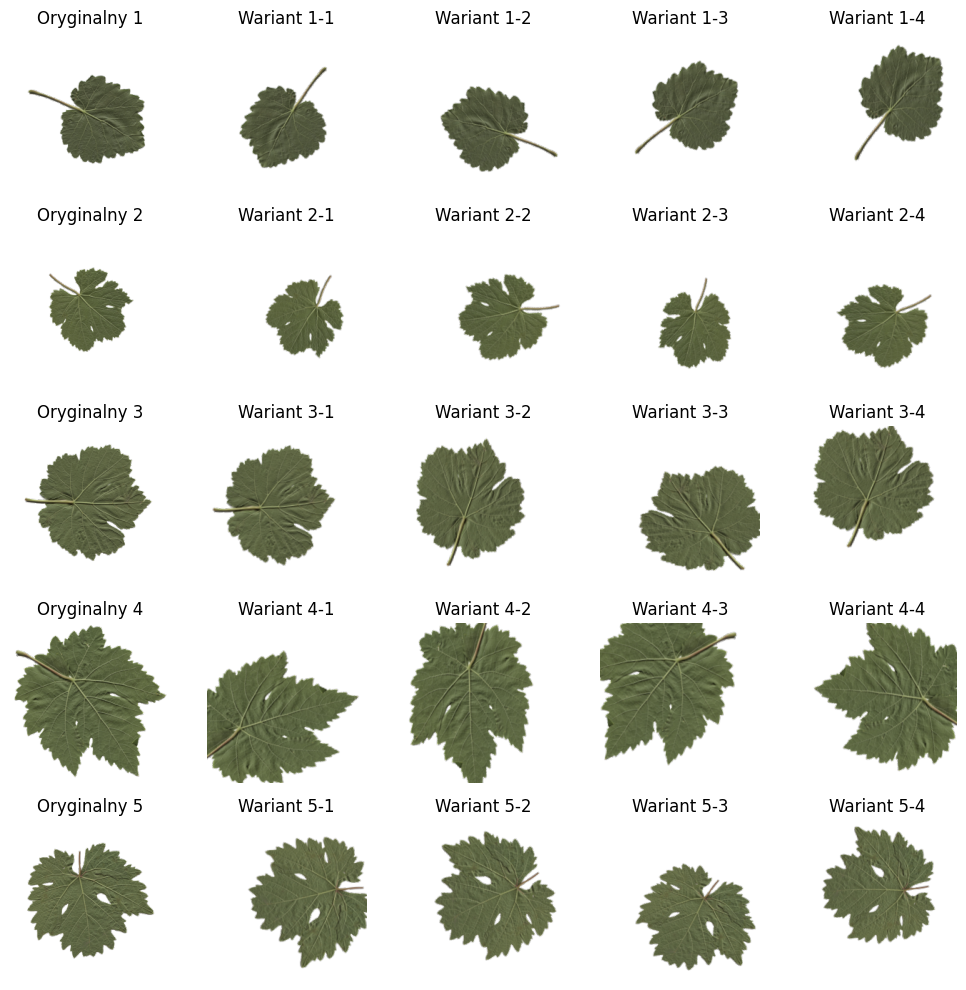

In [142]:
plot_augimages(np.random.choice(X_train, 5), resnet50_train_datagen)

In [143]:
# exclude the top (output) layer of the model
# initialize the model's weights with pre-trained weights from the ImageNet dataset
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false because we'd like to use pretrained layers
for layer in resnet50.layers:
    layer.trainable = False

# the last layer of the model is removed by taking the output from the last layer
x = resnet50.layers[-1].output


x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
predictions = Dense(5, activation='softmax')(x)

# the output tensor of the pre-trained ResNet-50 model
model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

## Model compilation

In [144]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [145]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

## Model training

In [146]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=50,
      callbacks=callback,
      verbose=2, #verbose=2 means that training progress will be displayed for each epoch, including metrics like loss and accuracy.
      )

Epoch 1/50
4/4 - 16s - loss: 2.0308 - accuracy: 0.1975 - val_loss: 1.8953 - val_accuracy: 0.1400 - 16s/epoch - 4s/step
Epoch 2/50
4/4 - 8s - loss: 1.8532 - accuracy: 0.2275 - val_loss: 1.9675 - val_accuracy: 0.2800 - 8s/epoch - 2s/step
Epoch 3/50
4/4 - 7s - loss: 1.8952 - accuracy: 0.2075 - val_loss: 1.6666 - val_accuracy: 0.3000 - 7s/epoch - 2s/step
Epoch 4/50
4/4 - 7s - loss: 1.6213 - accuracy: 0.3075 - val_loss: 1.4660 - val_accuracy: 0.2600 - 7s/epoch - 2s/step
Epoch 5/50
4/4 - 7s - loss: 1.5276 - accuracy: 0.3375 - val_loss: 1.4097 - val_accuracy: 0.3600 - 7s/epoch - 2s/step
Epoch 6/50
4/4 - 8s - loss: 1.4590 - accuracy: 0.3425 - val_loss: 1.2978 - val_accuracy: 0.4800 - 8s/epoch - 2s/step
Epoch 7/50
4/4 - 8s - loss: 1.3215 - accuracy: 0.4350 - val_loss: 1.2083 - val_accuracy: 0.6000 - 8s/epoch - 2s/step
Epoch 8/50
4/4 - 7s - loss: 1.2780 - accuracy: 0.4700 - val_loss: 1.2148 - val_accuracy: 0.6000 - 7s/epoch - 2s/step
Epoch 9/50
4/4 - 8s - loss: 1.2680 - accuracy: 0.4725 - val_lo

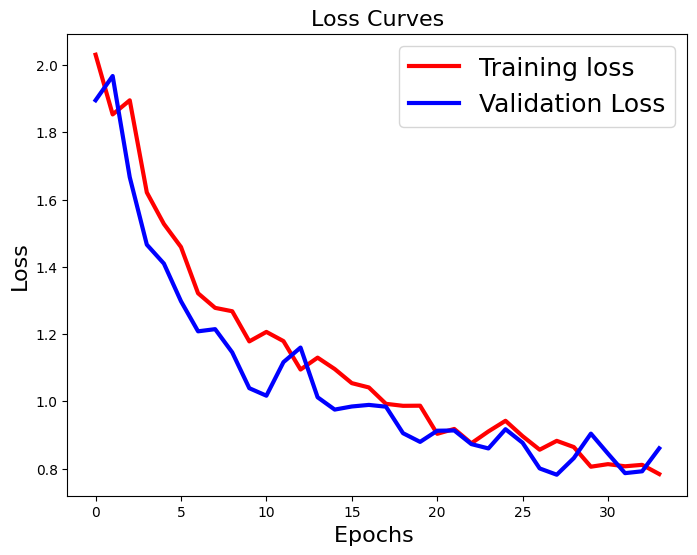

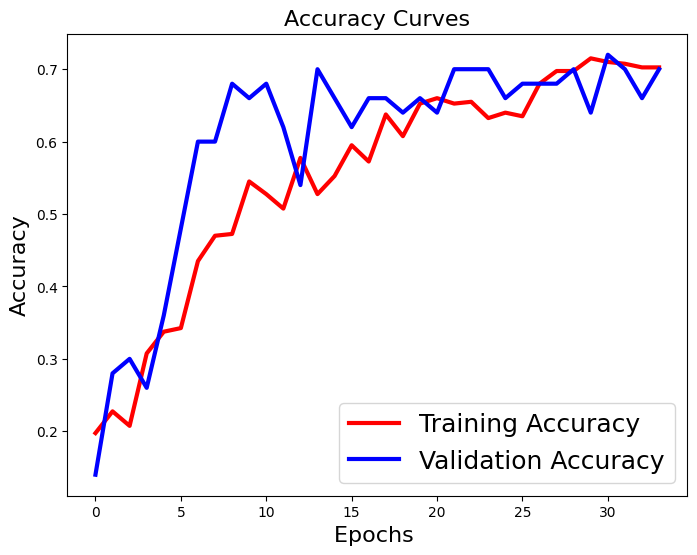

In [147]:
plot_history(history_resnet50)

In [148]:
predictions = np.argmax(model_resnet50.predict(test_generator_resnet50), axis=-1)
predictions[:10]

1/1 [==============================] - 1s 1s/step


array([1, 4, 2, 3, 3, 1, 0, 1, 0, 1])

In [149]:
test_generator_resnet50.labels[:10]

[2, 1, 2, 0, 3, 1, 0, 2, 0, 1]

In [150]:
df_test['class'][:10]

461      Buzgulu
313    Ala_Idris
449      Buzgulu
15            Ak
134       Dimnit
380    Ala_Idris
75            Ak
463      Buzgulu
13            Ak
311    Ala_Idris
Name: class, dtype: object

In [151]:
print(classification_report(test_generator_resnet50.labels, predictions))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        12
           1       0.62      0.67      0.64        12
           2       1.00      0.43      0.60         7
           3       0.80      0.73      0.76        11
           4       0.62      1.00      0.76         8

    accuracy                           0.70        50
   macro avg       0.75      0.70      0.69        50
weighted avg       0.74      0.70      0.69        50



We can observe, that model generalize best with hiperparameters above.

Generators without shuffle:
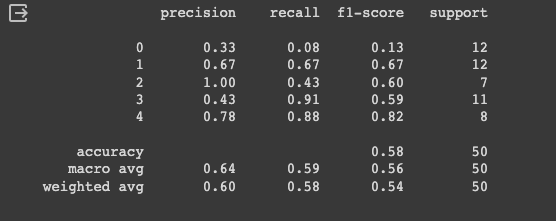

Generators with shuffle:
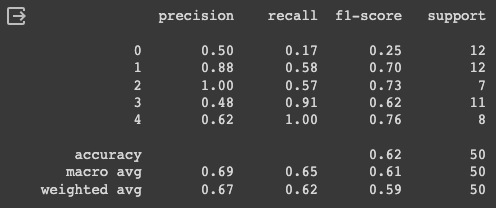

Model withoud dropout:
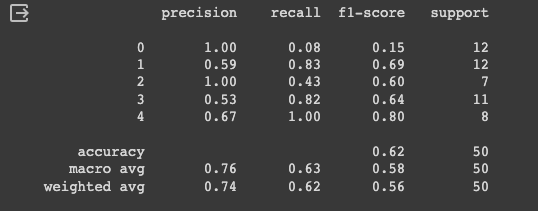

# Previous approach

In [98]:
img_width = 227
img_height = 227

EPOCHS = 50
BATCH_SIZE = 32

IMAGE_SHAPE = (img_width, img_height)

In [99]:
datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=0.1
)

In [100]:
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_train, 'label': y_train}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    subset=None,
    class_mode='categorical',
    shuffle=True
)

validation_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_val, 'label': y_val}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset=None,
    shuffle=True
)


test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({'image_path': X_test, 'label': y_test}),
    x_col='image_path',
    y_col='label',
    target_size=IMAGE_SHAPE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 400 validated image filenames belonging to 5 classes.
Found 50 validated image filenames belonging to 5 classes.
Found 50 validated image filenames.


In [70]:
CLASSES = set(y_train)

## Inception model

In [71]:
inception_v3 = InceptionV3(include_top= False , weights= None , input_shape = (img_width , img_height , 3))

In [72]:
url = 'https://github.com/kohpangwei/influence-release/raw/master/inception/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

weights_path = 'inception_v3_weights.h5'

response = requests.get(url)

if response.status_code == 200:
    with open(weights_path, 'wb') as f:
        f.write(response.content)
else:
    print("Nie udało się pobrać pliku.")

inception_v3.load_weights(weights_path)

In [73]:
#freezing the layers so that they are not affected by the training on the new dataset
for layer in inception_v3.layers:
    layer.trainable = False

In [74]:
last_layer = inception_v3.get_layer('mixed7') #I will put my output nodes on this layer
last_output = last_layer.output

In [152]:
x = tf.keras.layers.Flatten()(last_output)
# x = tf.keras.layers.Dense(100 , activation = 'relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5 , activation = 'softmax')(x)
pre_trained_model = tf.keras.models.Model(inputs = inception_v3.input , outputs = x)

In [153]:
pre_trained_model.compile(loss = tf.keras.losses.categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

In [156]:
history_pre_trained = pre_trained_model.fit(
    train_gen,
    epochs = EPOCHS,
    validation_data= validation_gen,
    callbacks=callback
    )

Epoch 1/50
13/13 [==============================] - 6s 428ms/step - loss: 9.3889e-04 - accuracy: 1.0000 - val_loss: 0.4229 - val_accuracy: 0.8000
Epoch 2/50
13/13 [==============================] - 3s 224ms/step - loss: 9.0985e-04 - accuracy: 1.0000 - val_loss: 0.4248 - val_accuracy: 0.8000
Epoch 3/50
13/13 [==============================] - 3s 235ms/step - loss: 8.8141e-04 - accuracy: 1.0000 - val_loss: 0.4236 - val_accuracy: 0.7800
Epoch 4/50
13/13 [==============================] - 3s 246ms/step - loss: 8.5826e-04 - accuracy: 1.0000 - val_loss: 0.4236 - val_accuracy: 0.7800
Epoch 5/50
13/13 [==============================] - 3s 218ms/step - loss: 8.3167e-04 - accuracy: 1.0000 - val_loss: 0.4270 - val_accuracy: 0.7800
Epoch 6/50
13/13 [==============================] - 3s 219ms/step - loss: 8.1274e-04 - accuracy: 1.0000 - val_loss: 0.4344 - val_accuracy: 0.7800
Epoch 7/50
13/13 [==============================] - 3s 232ms/step - loss: 7.8931e-04 - accuracy: 1.0000 - val_loss: 0.4250 -

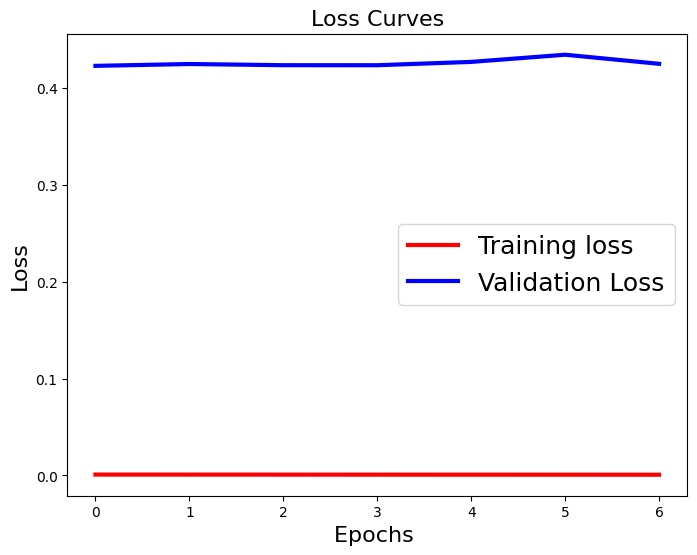

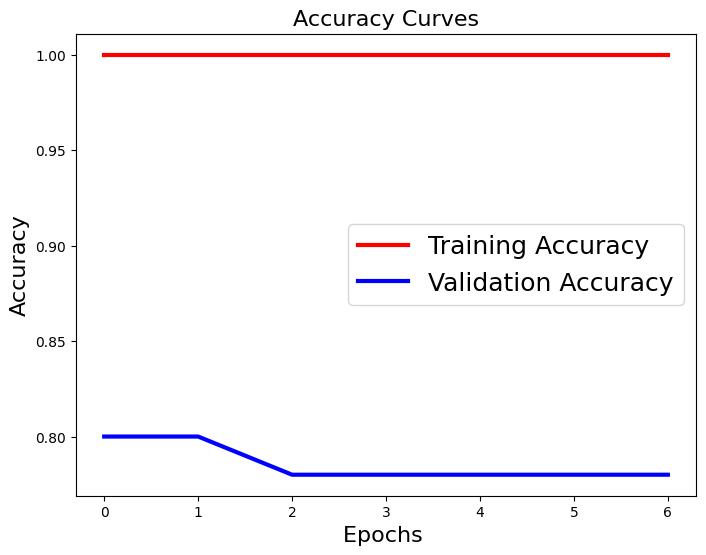

In [157]:
plot_history(history_pre_trained)

## BASIC SEQUENTIAL MODEL

In [79]:
model = Sequential()

# Add a 2D convolutional layer with 32 filters of size 3x3 and ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))

# Add a MaxPooling layer to reduce the data size
model.add(MaxPooling2D((2, 2)))

# Add another 2D convolutional layer with 64 filters of size 3x3 and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Add a 2D convolutional layer with 128 filters of size 3x3 and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the data into a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))

# Add an output layer with one neuron and a sigmoid activation function (binary classification)
model.add(Dense(len(CLASSES), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])


In [80]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)

Epoch 1/20
13/13 [==============================] - 8s 315ms/step - loss: 1.6440 - accuracy: 0.2050 - val_loss: 1.5587 - val_accuracy: 0.3400
Epoch 2/20
13/13 [==============================] - 3s 216ms/step - loss: 1.5596 - accuracy: 0.3225 - val_loss: 1.5953 - val_accuracy: 0.1800
Epoch 3/20
13/13 [==============================] - 3s 219ms/step - loss: 1.4775 - accuracy: 0.3725 - val_loss: 1.4830 - val_accuracy: 0.3800
Epoch 4/20
13/13 [==============================] - 3s 248ms/step - loss: 1.3490 - accuracy: 0.5225 - val_loss: 1.5527 - val_accuracy: 0.2000
Epoch 5/20
13/13 [==============================] - 3s 238ms/step - loss: 1.2936 - accuracy: 0.4650 - val_loss: 1.3641 - val_accuracy: 0.4400
Epoch 6/20
13/13 [==============================] - 3s 228ms/step - loss: 1.1390 - accuracy: 0.6225 - val_loss: 1.3098 - val_accuracy: 0.4400
Epoch 7/20
13/13 [==============================] - 3s 222ms/step - loss: 0.9475 - accuracy: 0.6675 - val_loss: 1.4322 - val_accuracy: 0.4800
Epoch 

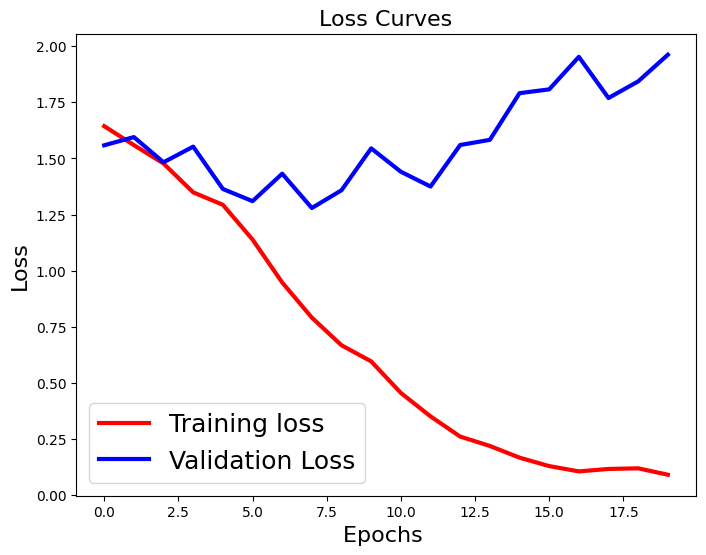

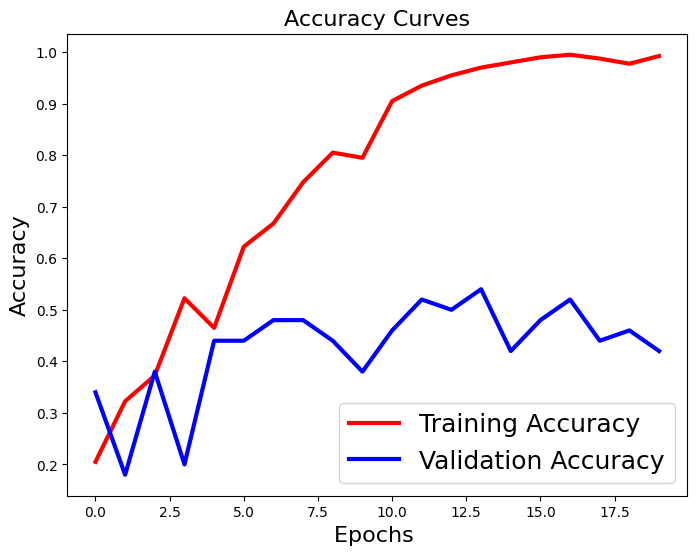

In [81]:
plot_history(history)

In [82]:
model.save('basic_model.keras')

# Model 1

### WITH DROPOUTS, BATCH_NORM AND EARLY STOPPING

In [83]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

In [84]:
# Compile the model
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_gen.n//validation_gen.batch_size

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose=1
)

<ipython-input-84-22eb5d98f54d>:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,


Epoch 1/20
12/12 [==============================] - 5s 258ms/step - loss: 2.0523 - accuracy: 0.2891 - val_loss: 4.9732 - val_accuracy: 0.2812
Epoch 2/20
12/12 [==============================] - 4s 285ms/step - loss: 1.2485 - accuracy: 0.4973 - val_loss: 6.8249 - val_accuracy: 0.3125
Epoch 3/20
12/12 [==============================] - 3s 234ms/step - loss: 0.9784 - accuracy: 0.6522 - val_loss: 12.5464 - val_accuracy: 0.2500
Epoch 4/20
12/12 [==============================] - 3s 239ms/step - loss: 0.7214 - accuracy: 0.7500 - val_loss: 11.9651 - val_accuracy: 0.3125
Epoch 5/20
12/12 [==============================] - 4s 297ms/step - loss: 0.5028 - accuracy: 0.8125 - val_loss: 12.8272 - val_accuracy: 0.2812
Epoch 6/20
12/12 [==============================] - 3s 231ms/step - loss: 0.3368 - accuracy: 0.8723 - val_loss: 14.4917 - val_accuracy: 0.1875
Epoch 7/20
12/12 [==============================] - 4s 300ms/step - loss: 0.3113 - accuracy: 0.9049 - val_loss: 19.1573 - val_accuracy: 0.1562
E

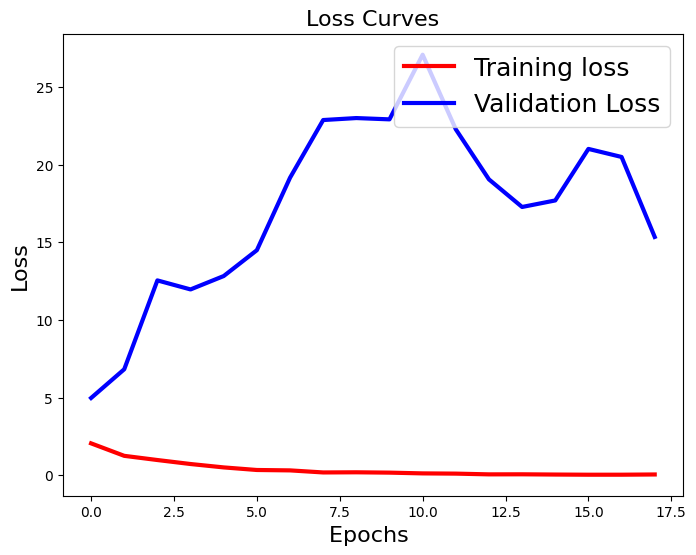

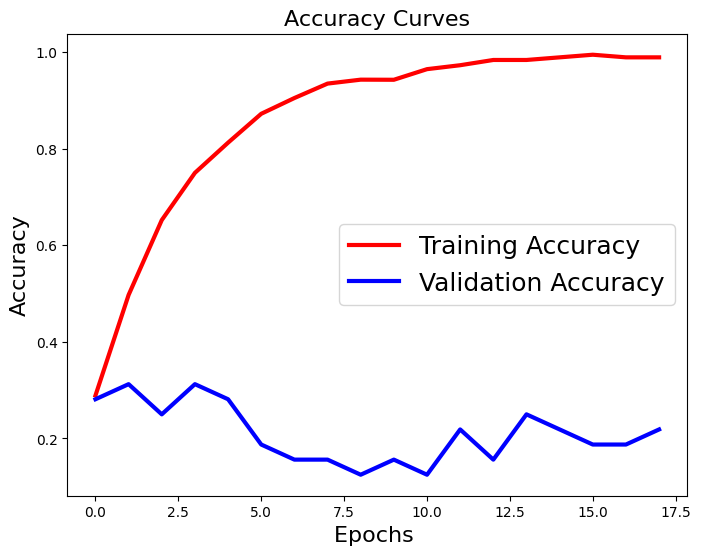

In [85]:
plot_history(history)

In [86]:
model.save('model1.keras')

In [87]:


model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['accuracy'])

# Model 2

In [88]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen),
    callbacks=callback
)

Epoch 1/20
13/13 [==============================] - 6s 243ms/step - loss: 2.1595 - accuracy: 0.2900 - val_loss: 1.9831 - val_accuracy: 0.2600
Epoch 2/20
13/13 [==============================] - 4s 287ms/step - loss: 0.4827 - accuracy: 0.8450 - val_loss: 2.3411 - val_accuracy: 0.1600
Epoch 3/20
13/13 [==============================] - 3s 228ms/step - loss: 0.2425 - accuracy: 0.9375 - val_loss: 3.2584 - val_accuracy: 0.1600
Epoch 4/20
13/13 [==============================] - 3s 229ms/step - loss: 0.1545 - accuracy: 0.9675 - val_loss: 4.3758 - val_accuracy: 0.1600
Epoch 5/20
13/13 [==============================] - 4s 297ms/step - loss: 0.0707 - accuracy: 0.9975 - val_loss: 5.2579 - val_accuracy: 0.1600
Epoch 6/20
13/13 [==============================] - 3s 228ms/step - loss: 0.0344 - accuracy: 1.0000 - val_loss: 5.9619 - val_accuracy: 0.1800
Epoch 7/20
13/13 [==============================] - 3s 237ms/step - loss: 0.0292 - accuracy: 1.0000 - val_loss: 6.6396 - val_accuracy: 0.2200
Epoch 

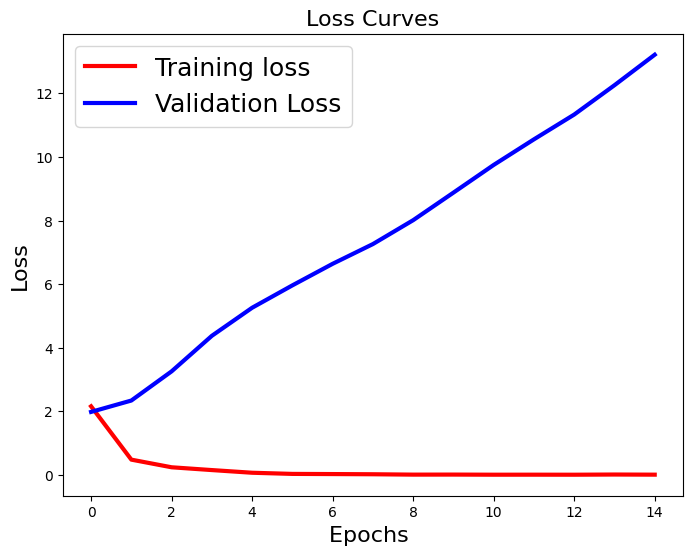

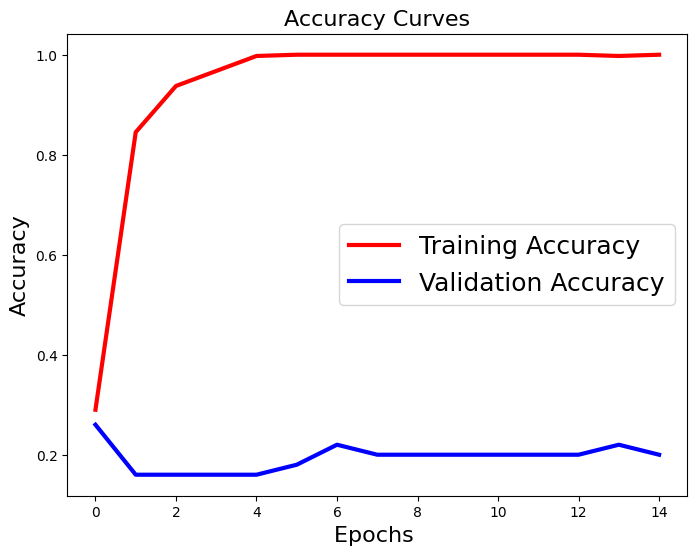

In [89]:
plot_history(history)